In [1]:
import os
import torch


model_dir = 'checkpoints/swiss-roll_T=100_beta_min=0.0001_beta_max=0.001'
model_path = os.path.join(model_dir, 'model.pt')

model = torch.load(model_path)

samples = model.sample(1000, 'cuda')

In [2]:
import numpy as np
samples = np.stack(samples)

In [3]:
samples.shape

(101, 1000, 2)

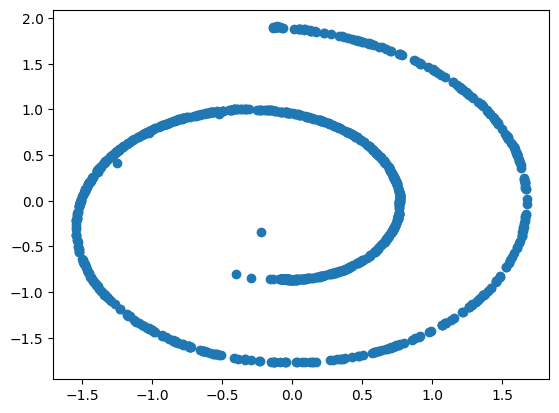

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
t = 100
ax.scatter(samples[t][:,0], samples[t][:,1])



class Pretrained(torch.utils.data.Dataset):
    def __init__(self, samples=None):
        super().__init__()
        if samples is None:
            model_dir = 'checkpoints/swiss-roll_T=100_beta_min=0.0001_beta_max=0.001'
            model_path = os.path.join(model_dir, 'model.pt')

            model = torch.load(model_path)

            self.samples = np.stack(model.sample(1000, 'cuda').tranpose(1, 0, 2))
        else:
            self.samples = samples
        
    def __getitem__(self, idx):
        samples = self.samples[idx]
        
        return torch.from_numpy(samples).float()
    
    def __len__(self):
        return len(self.samples)
    

    
dset = Pretrained(samples.transpose(1,0,2))
    



In [5]:
dloader = torch.utils.data.DataLoader(dset, batch_size = 32, shuffle=True)
x_batch = next(iter(dloader))

In [6]:
x_batch.shape

torch.Size([32, 101, 2])

In [32]:
import torch.nn as nn
import ipdb
import torch.nn.functional as F


class Koopman(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        latent_dim = 64
        hidden = 64
        self.encoder = nn.Sequential(nn.Linear(input_dim + 1, hidden), 
                                     nn.ReLU(), 
                                     nn.Linear(hidden, hidden),
                                    nn.ReLU(), 
                                    nn.Linear(hidden, hidden), 
                                    nn.ReLU(), 
                                    nn.Linear(hidden, latent_dim))
        
        self.decoder = nn.Sequential(nn.Linear(latent_dim + 1, hidden), nn.ReLU(), 
                                    nn.Linear(hidden, hidden),
                                    nn.ReLU(),
                                    nn.Linear(hidden, hidden),
                                    nn.ReLU(),
                                    nn.Linear(hidden, input_dim))
        
        self.K = nn.Parameter(torch.eye(latent_dim))
        
    def encode(self, x, t):
        #xt = torch.cat((x, t), -1)
        xt = self.cat(x, t)
        return self.encoder(xt)
    
    def cat(self, x, t):
        t = t.unsqueeze(0).repeat(x.shape[0], 1)
        xt = torch.cat((x, t), -1)
        return xt
    
    def decode(self, z, t):
        #zt = torch.cat((z, t), -1)
        zt = self.cat(z, t)
        return self.decoder(zt)
        
    def forward(self, x, t):
        zt = self.encode(x, t)
        zt1 = zt @ self.K
        return self.decode(zt1, t)
    
    

koop = Koopman(2)

epochs = 50

opt = torch.optim.Adam(koop.parameters(), lr=1e-3)

T = 101

for epoch in range(1, epochs + 1):
    for ix, x_batch in enumerate(dloader):
        batch_size = x_batch.shape[0]
        #t = torch.randint(1, T+1, size=(batch_size, 1))
        t = torch.randint(1, T, size=(1,))
        
        x_batch_t = x_batch[:, t[0]]
        y_batch_t = x_batch[:, t[0] + 1]
        
        z = koop.encode(x_batch_t, t)
        z_next = z @ koop.K
        
        loss = F.mse_loss(koop.decode(z_next, t), y_batch_t)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} Loss: {loss.item():.3f}")
        
        

Epoch: 5 Loss: 0.285
Epoch: 10 Loss: 0.084
Epoch: 15 Loss: 0.004
Epoch: 20 Loss: 0.003
Epoch: 25 Loss: 0.003
Epoch: 30 Loss: 0.002
Epoch: 35 Loss: 0.000
Epoch: 40 Loss: 0.001
Epoch: 45 Loss: 0.007
Epoch: 50 Loss: 0.001


In [42]:
## Evaluate
print(x_batch_t.shape)
dloader = torch.utils.data.DataLoader(dset, batch_size = 300, shuffle=True)
if True:
    with torch.no_grad():
        x_batch = next(iter(dloader))
        elem = x_batch
        xT = elem[:, 0]
        #zT = koop.encode(xT, torch.Tensor([1]))
        xs = []
        for i in range(1, T):
            xs.append(xT)
            xT = koop.forward(xT, torch.Tensor([i]))
            
            #zT = zT @ koop.K

        #z0 = koop.decode(zT, torch.Tensor([100]))
        
xs = torch.stack(xs)
print(xT.shape)

        

torch.Size([8, 2])
torch.Size([300, 2])


/tmp/ipykernel_311879/177315499.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


torch.Size([99, 300, 2])

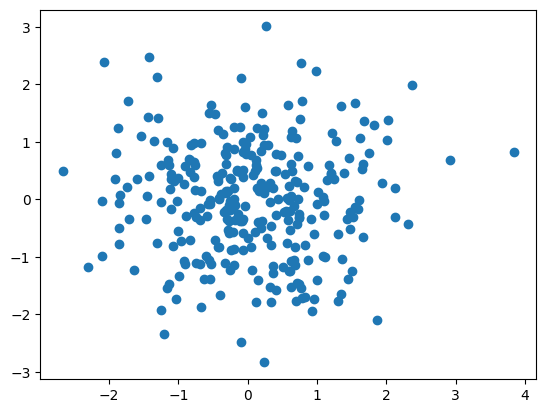

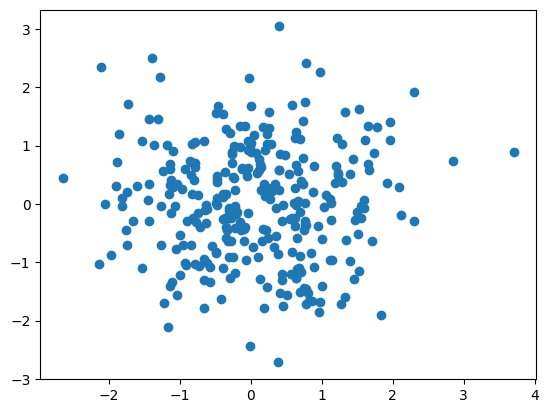

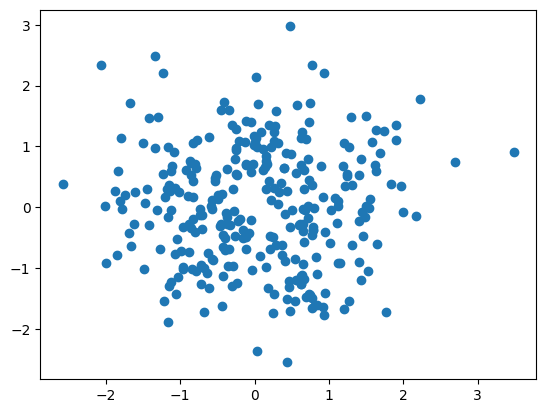

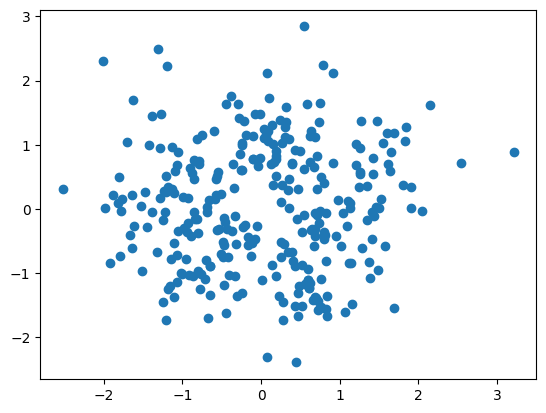

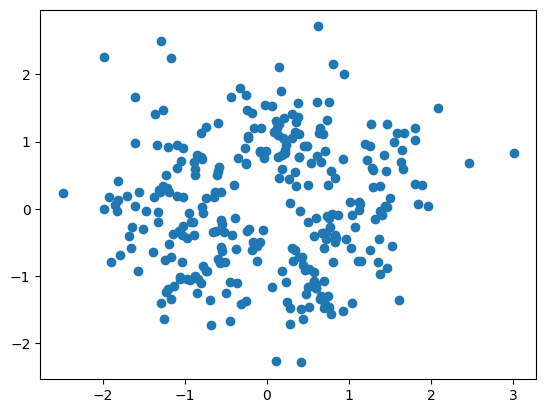

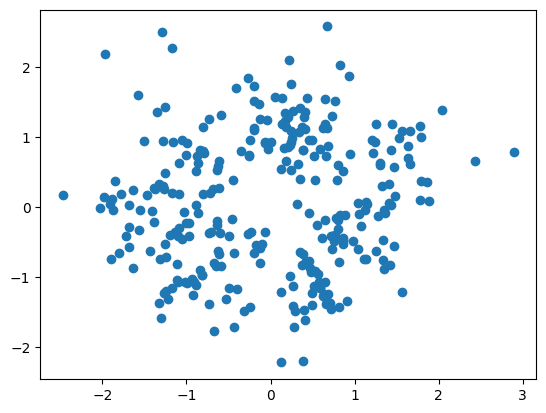

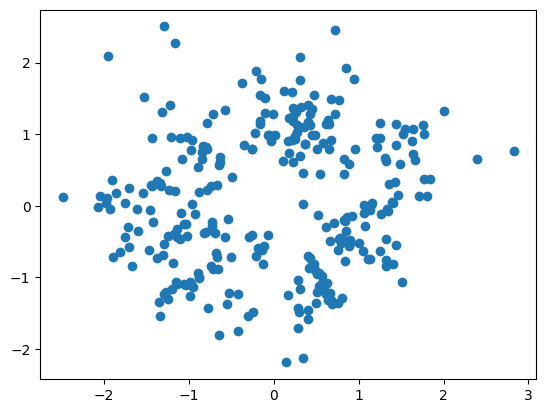

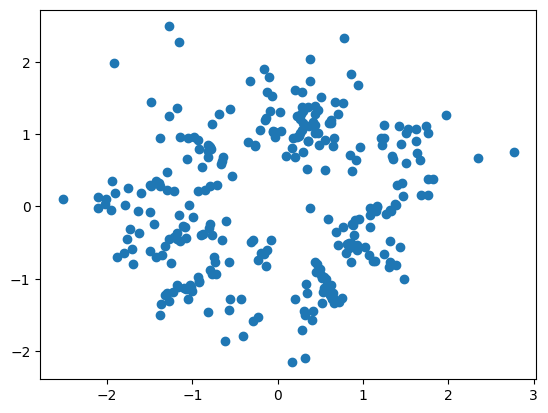

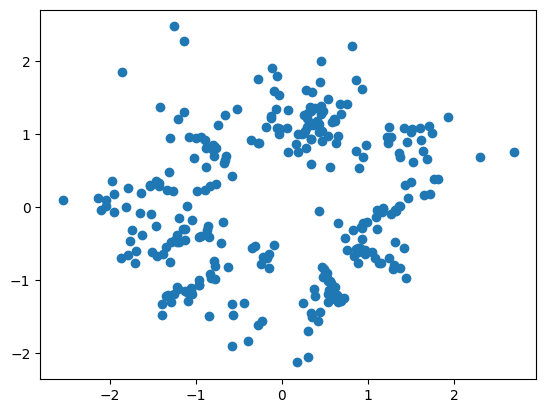

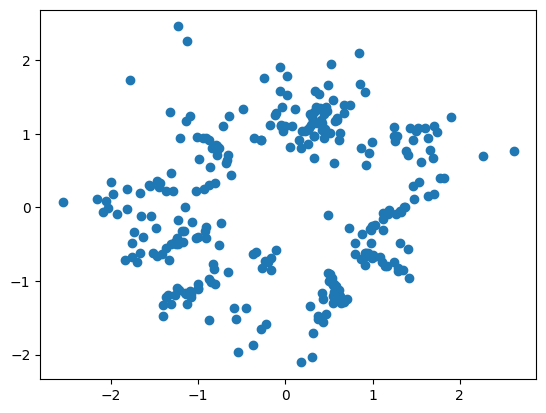

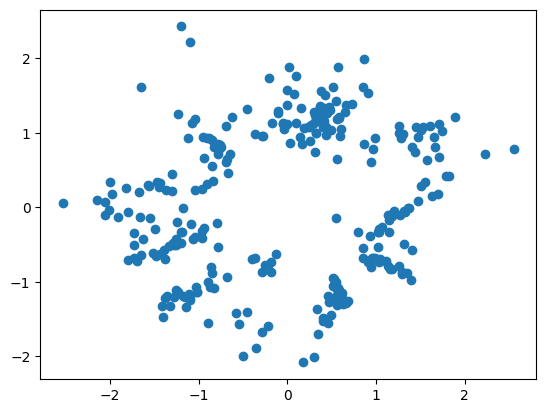

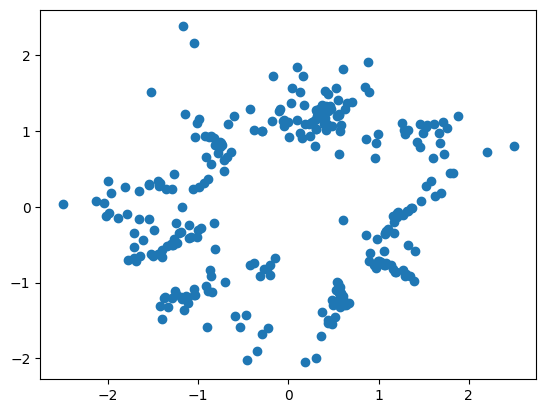

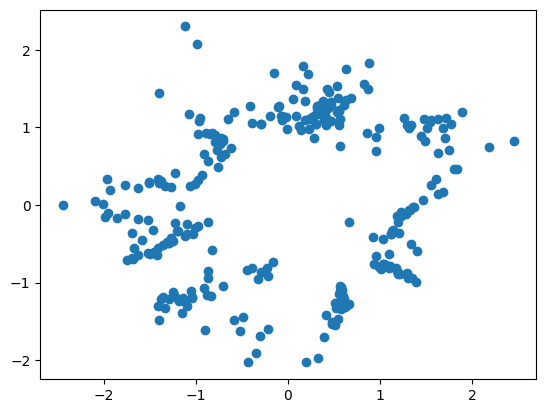

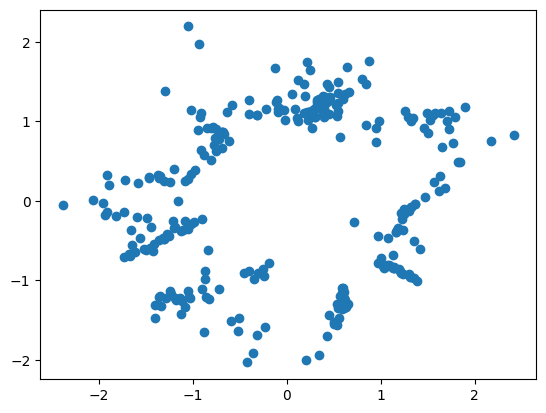

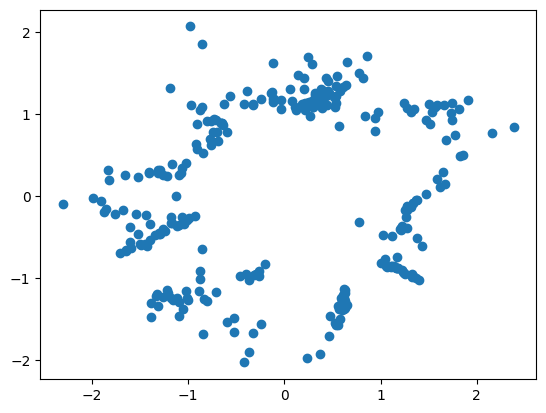

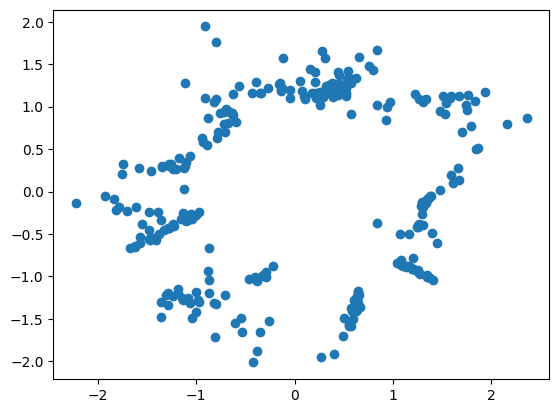

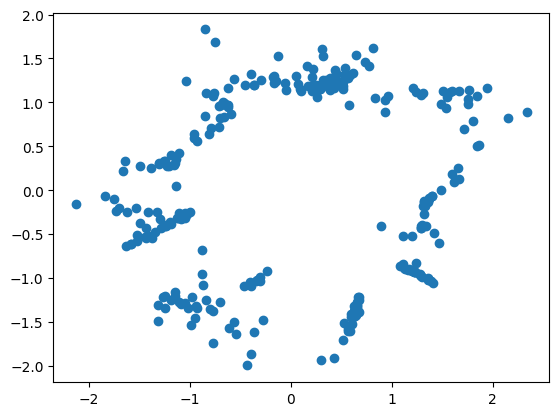

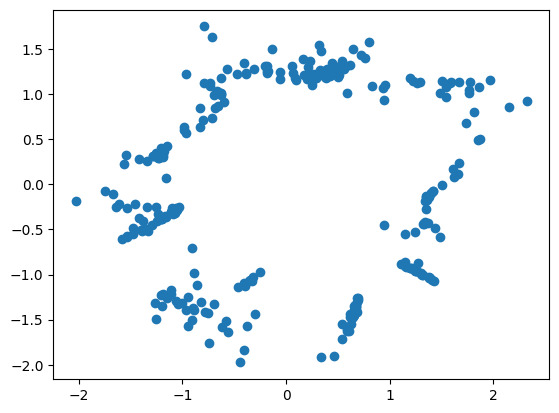

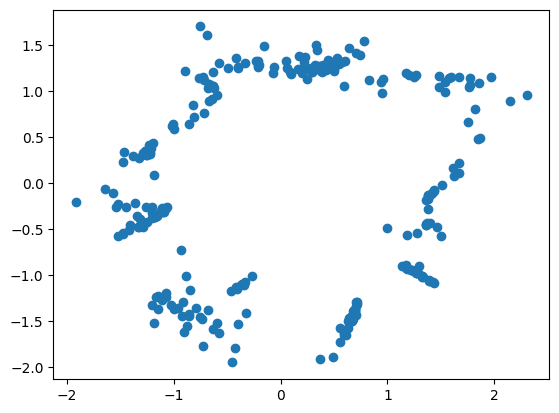

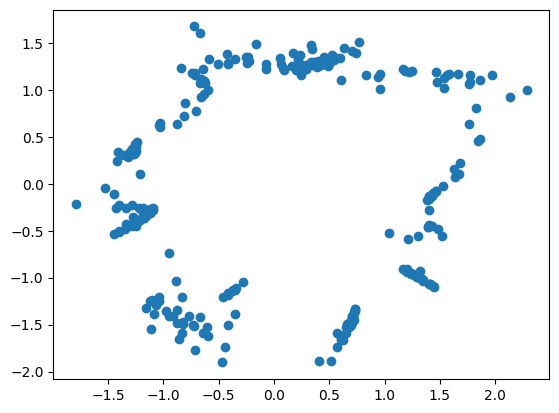

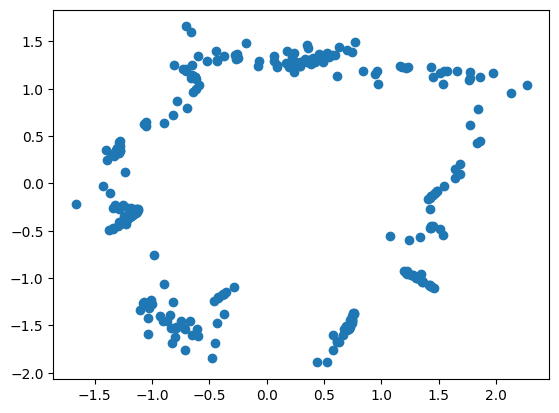

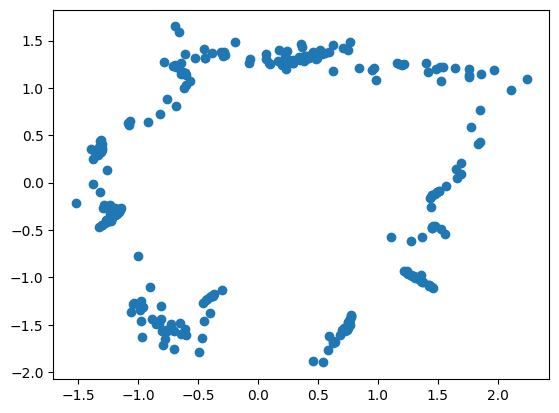

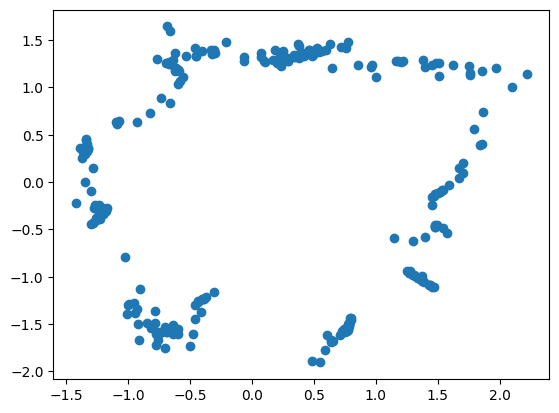

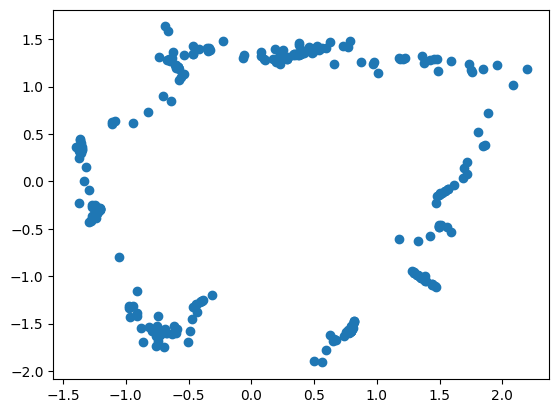

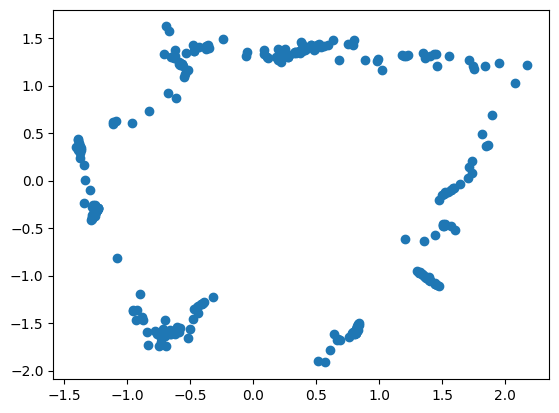

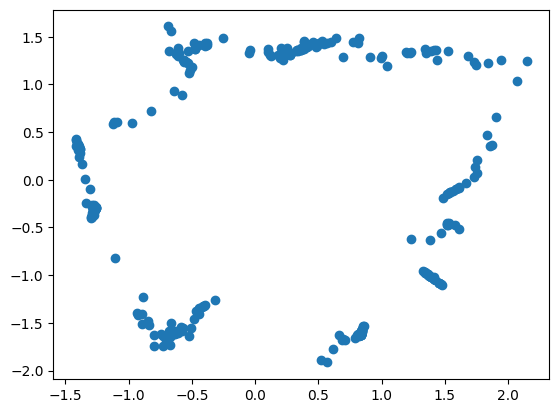

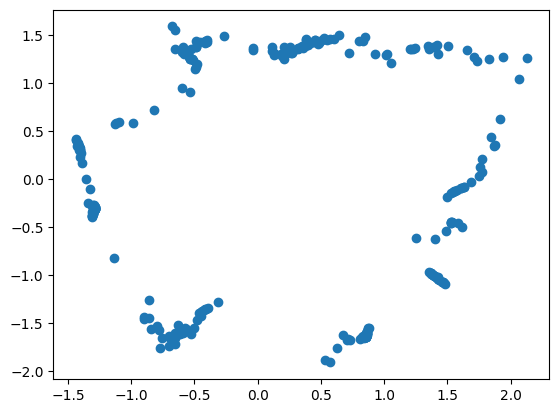

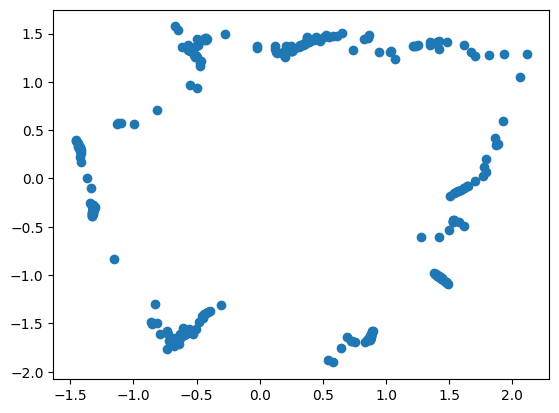

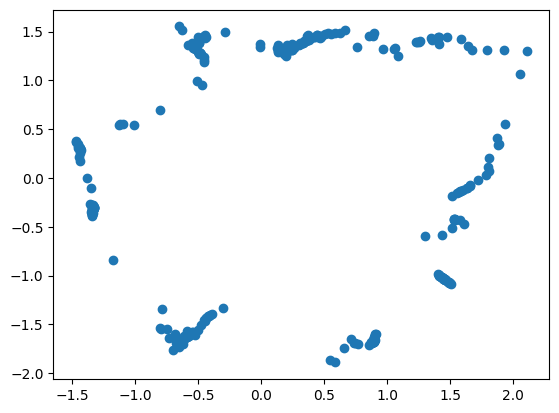

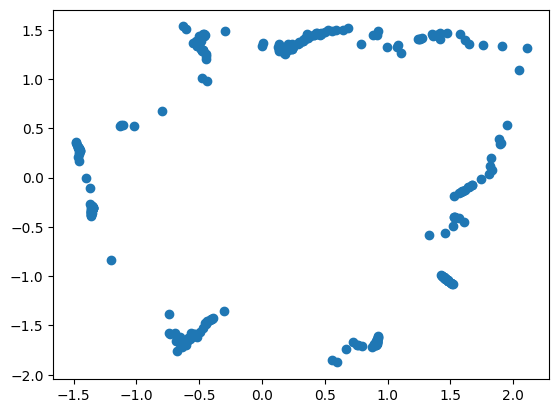

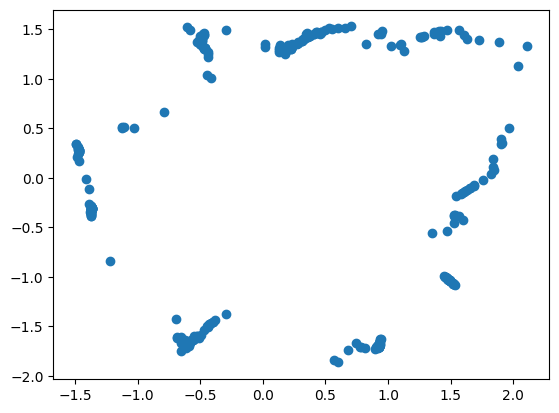

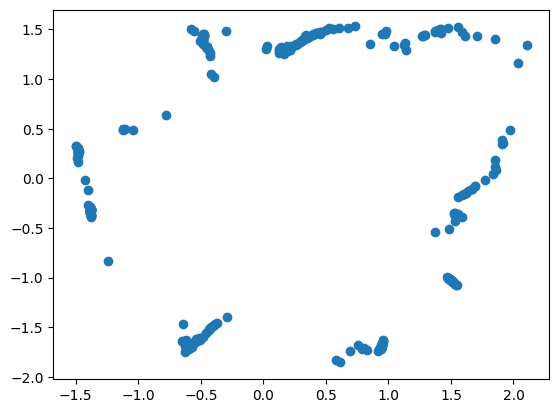

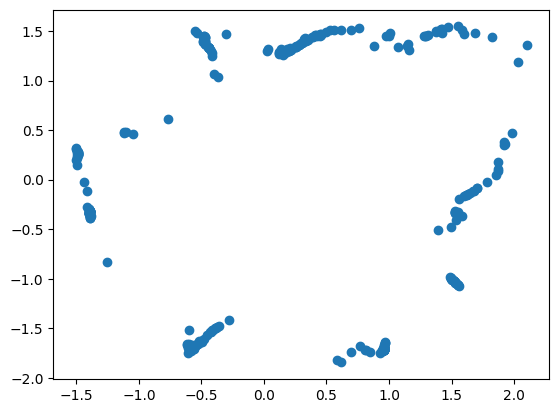

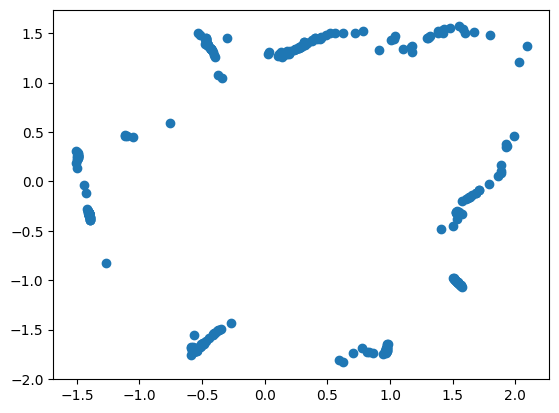

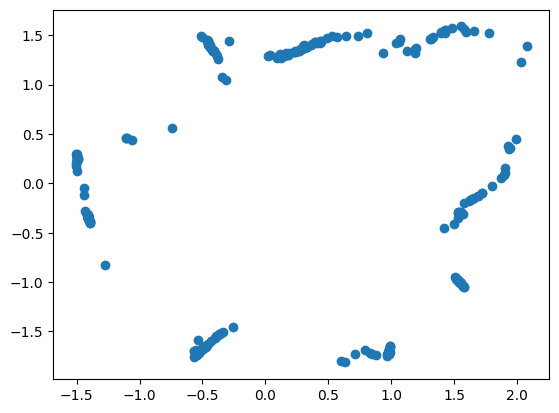

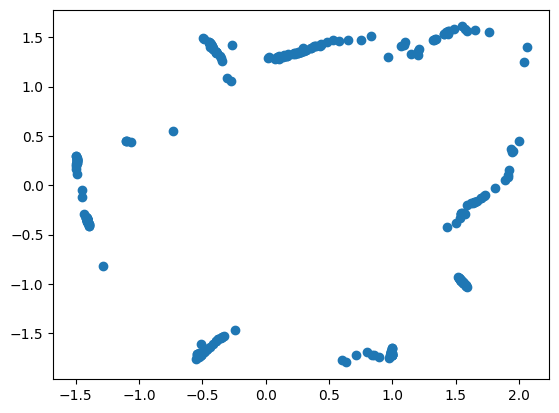

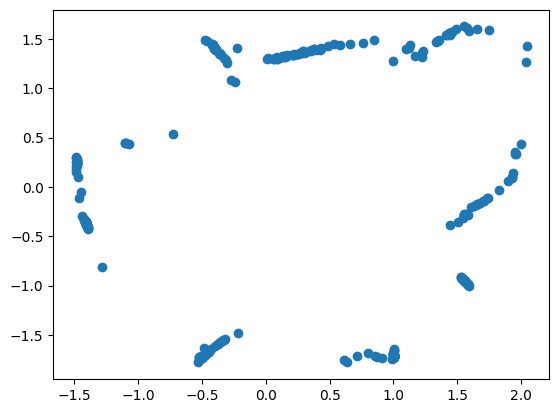

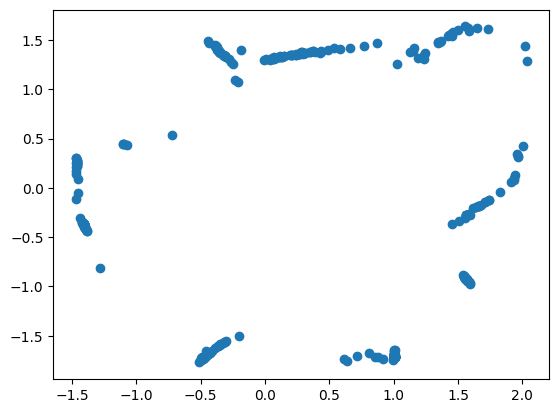

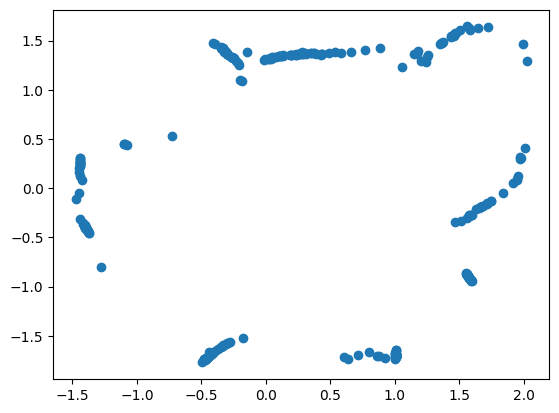

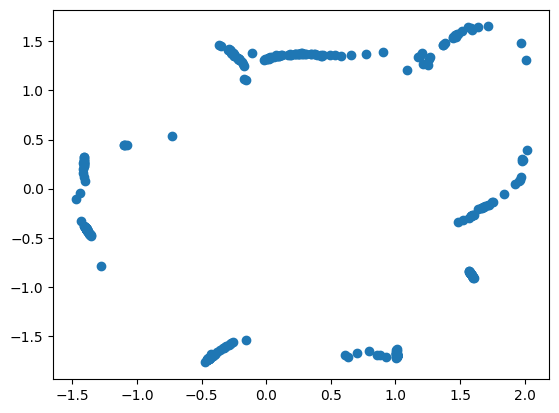

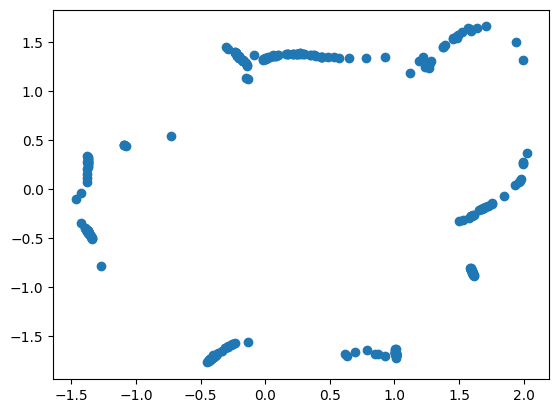

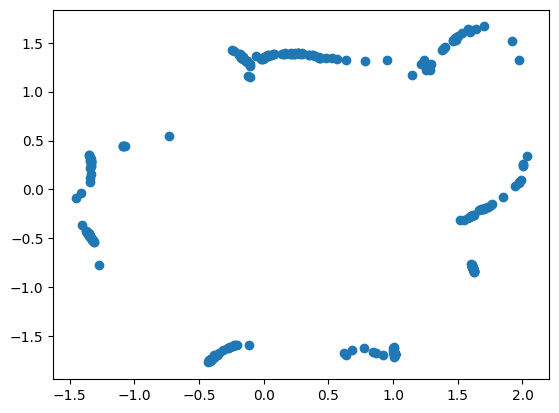

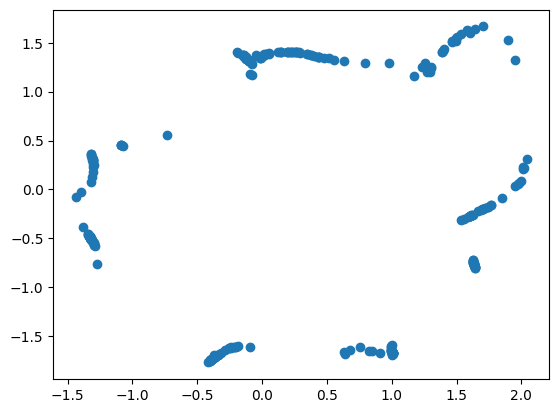

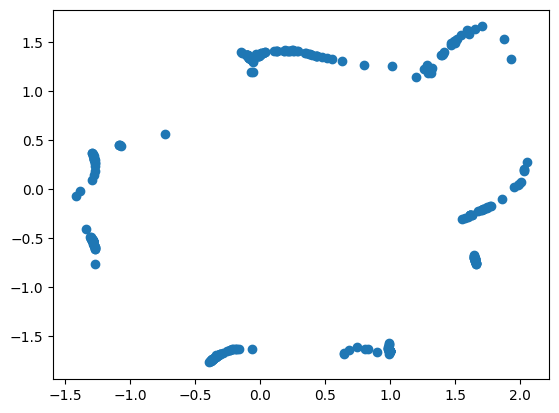

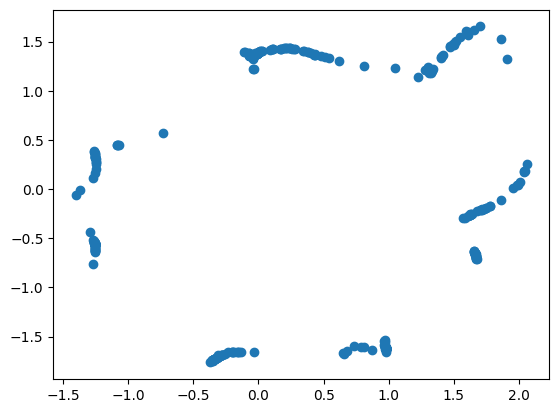

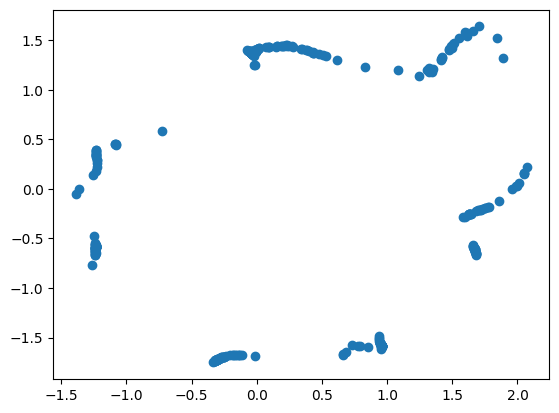

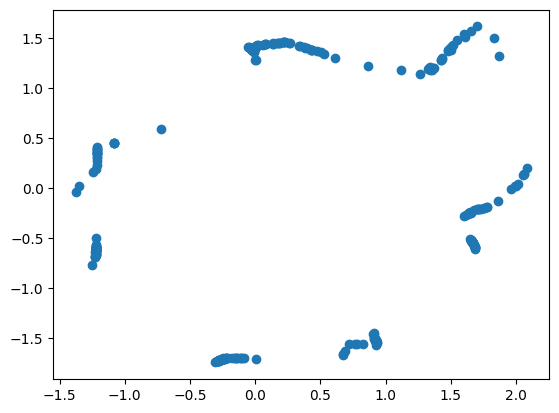

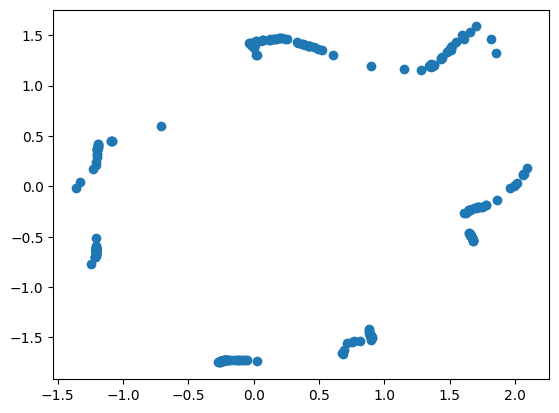

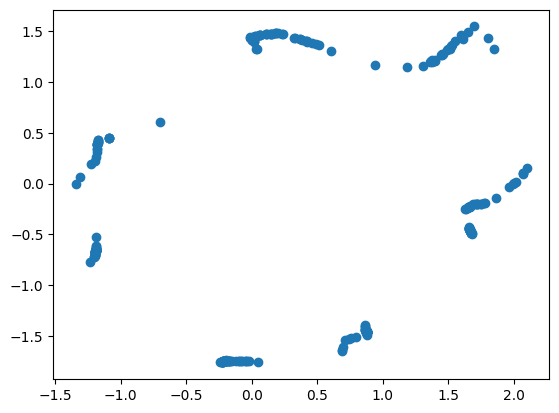

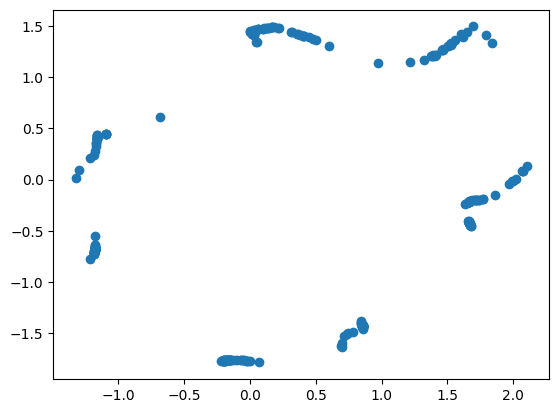

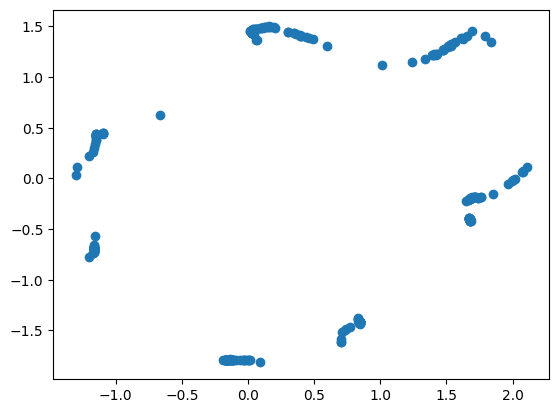

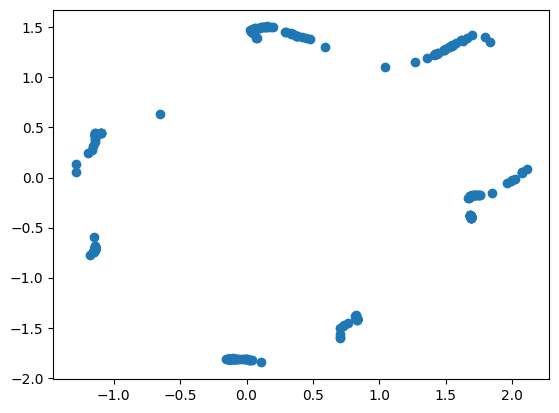

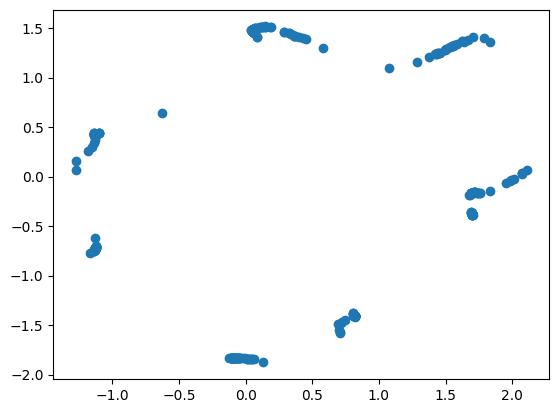

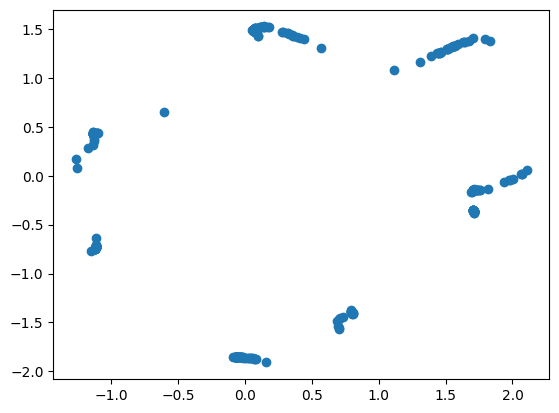

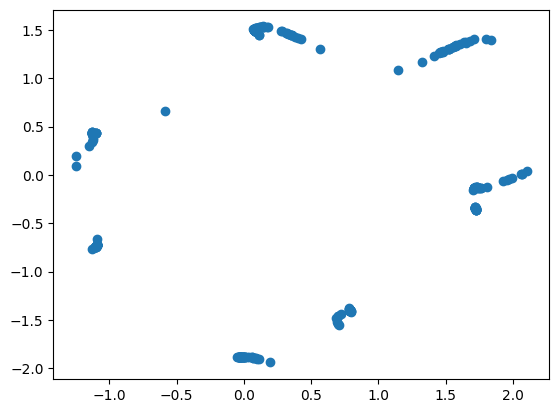

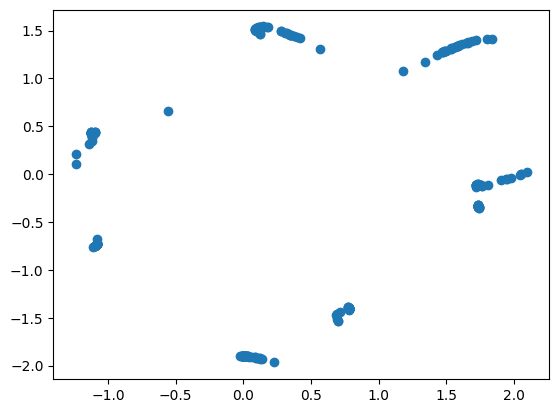

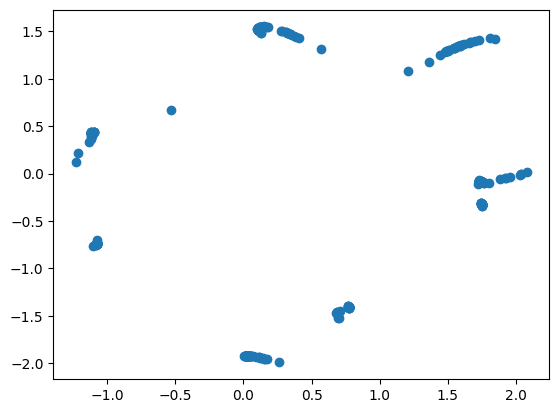

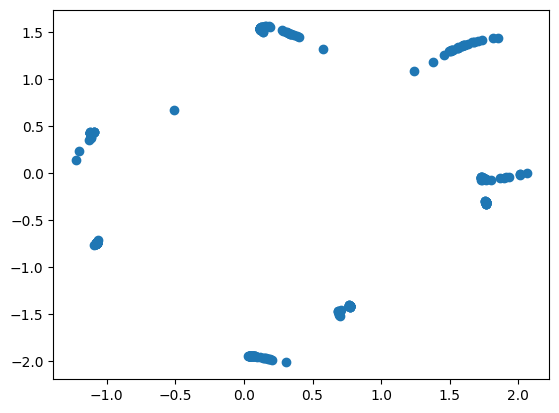

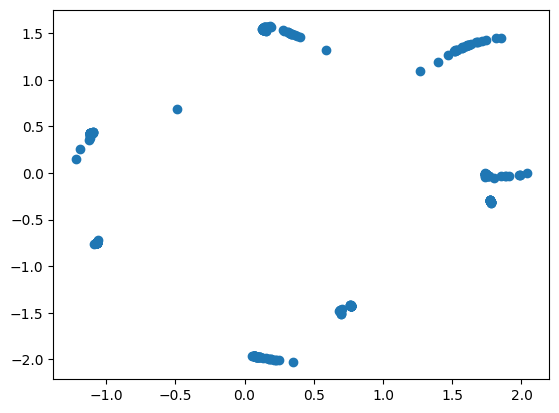

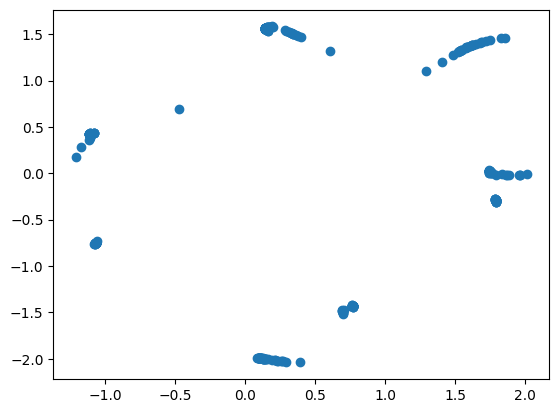

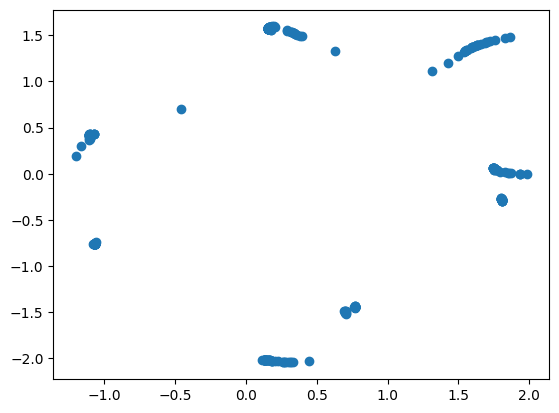

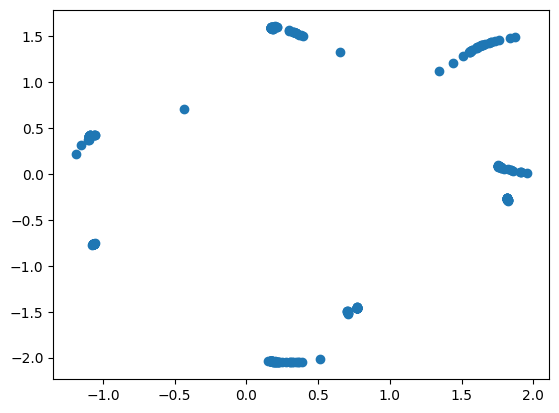

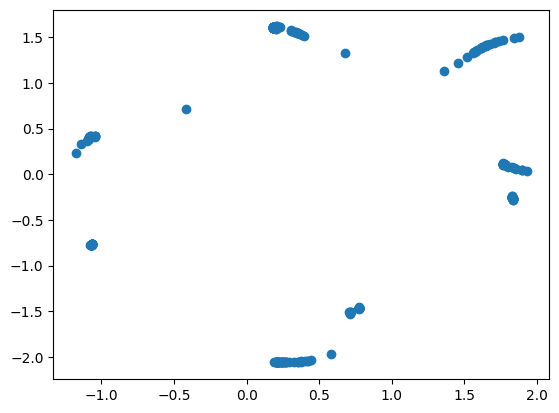

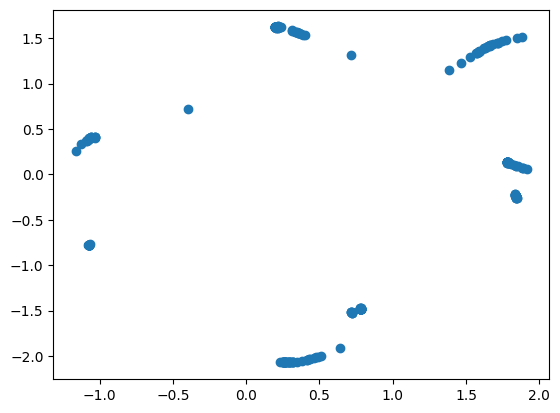

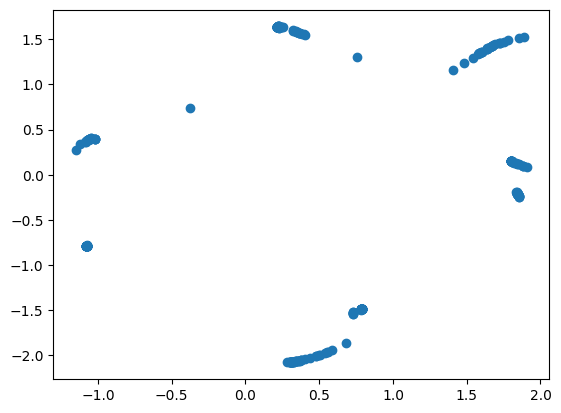

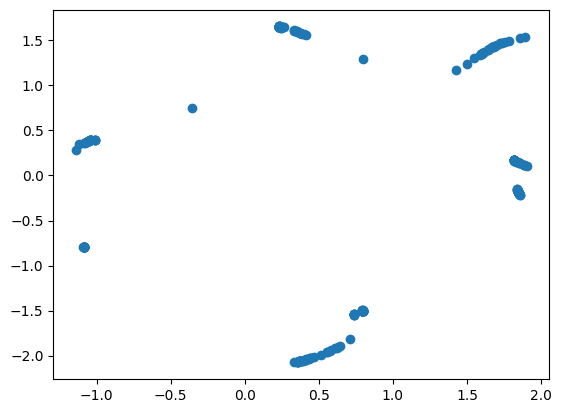

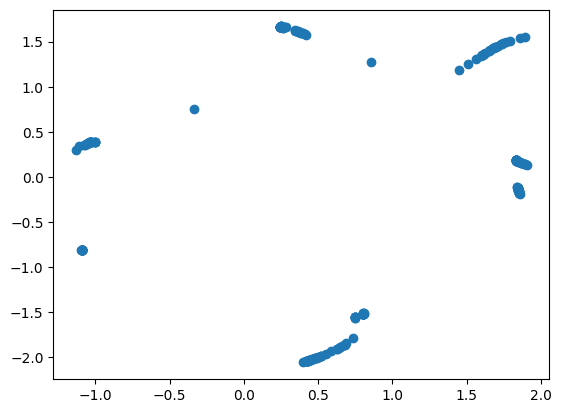

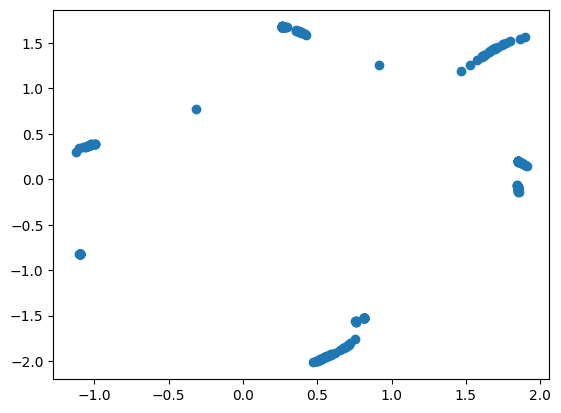

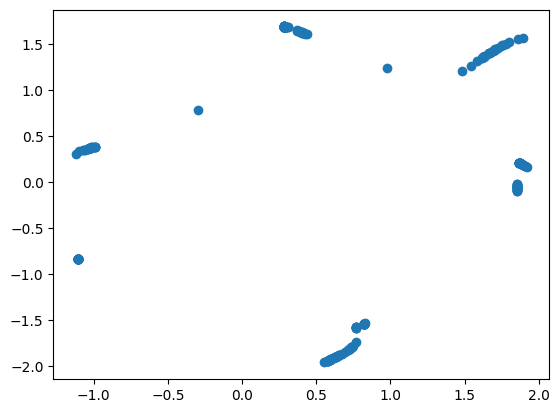

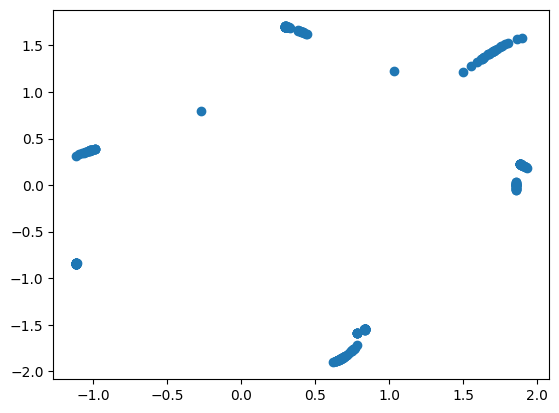

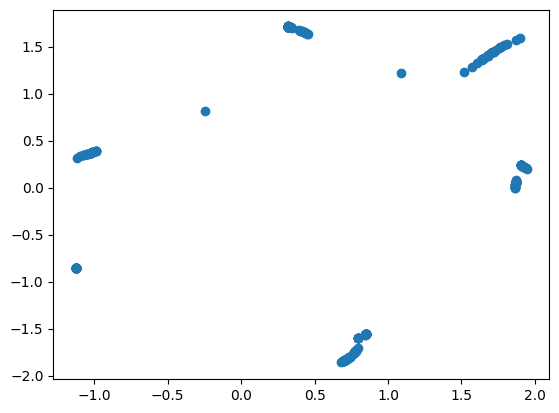

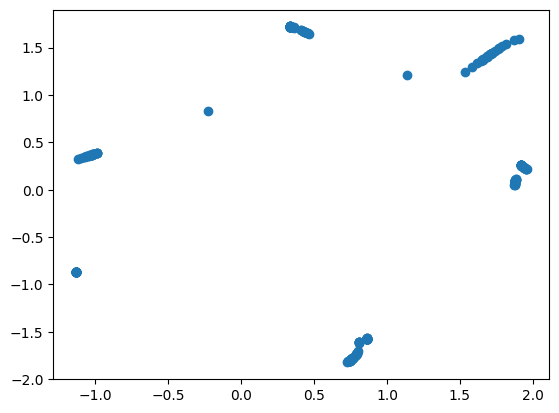

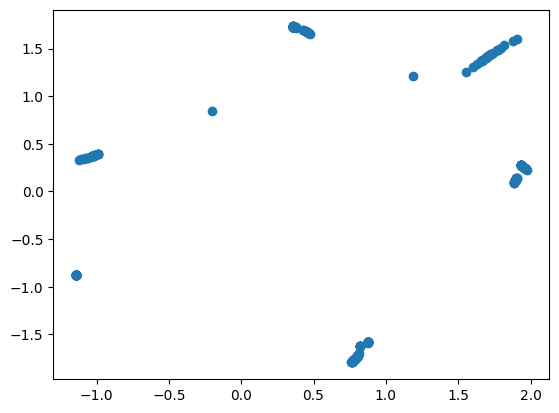

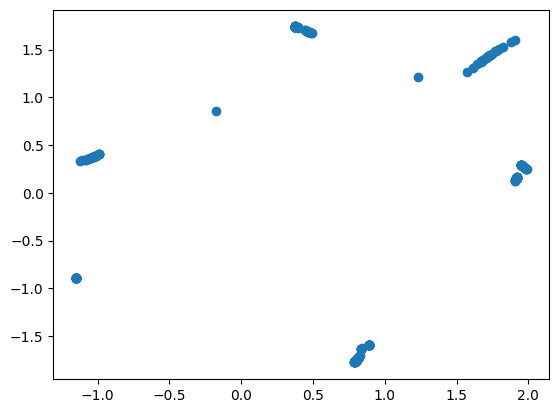

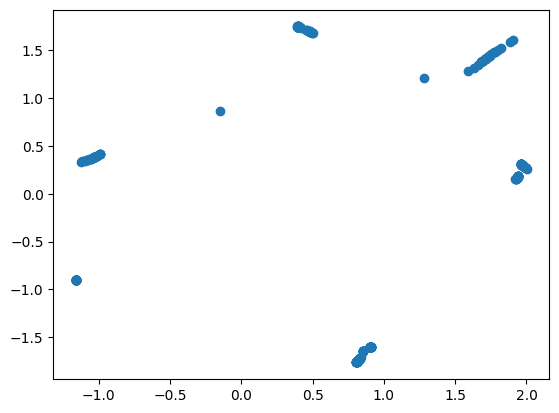

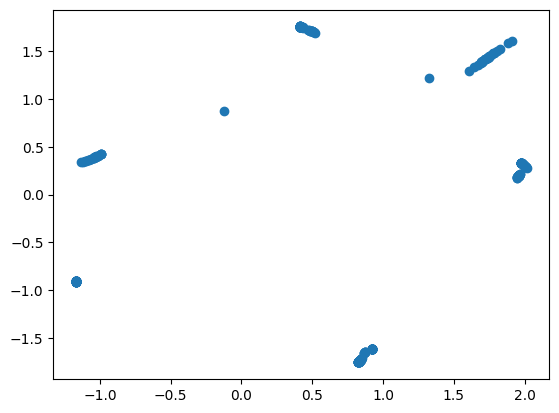

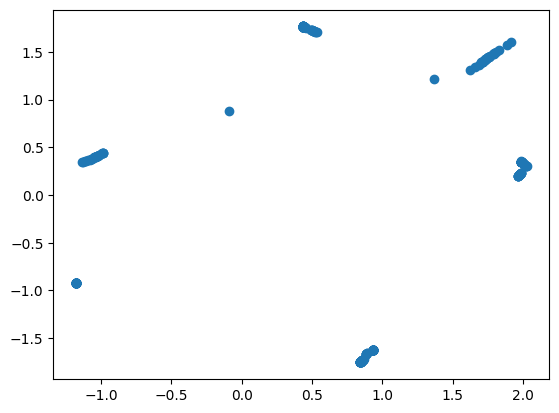

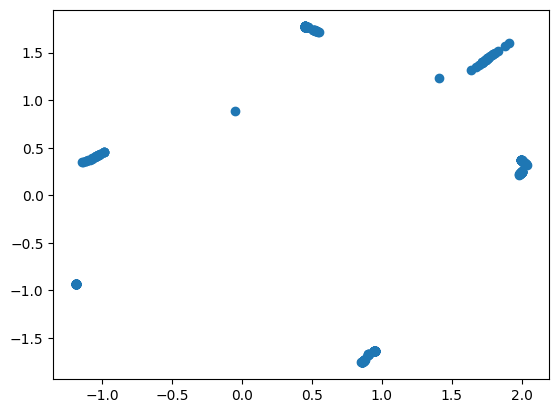

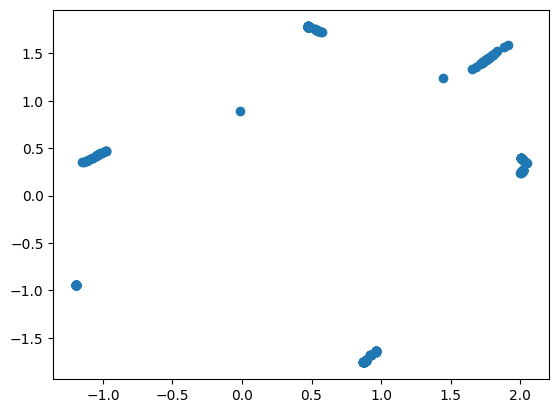

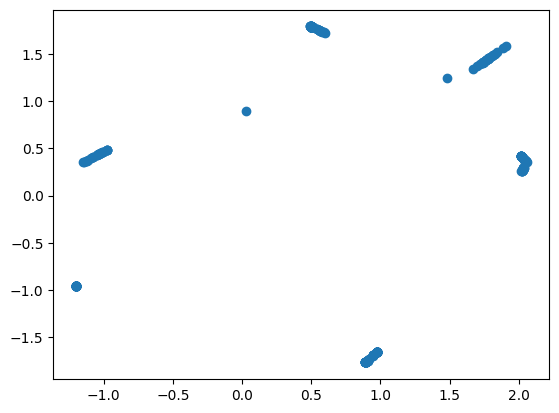

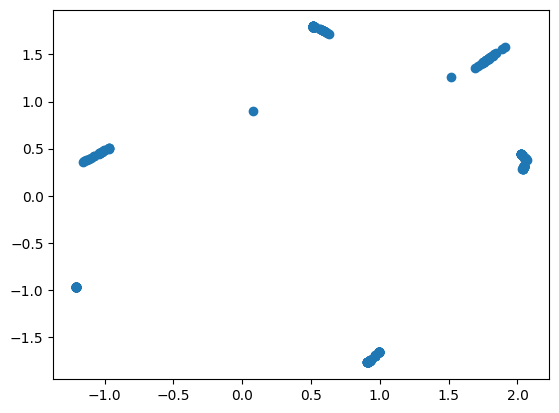

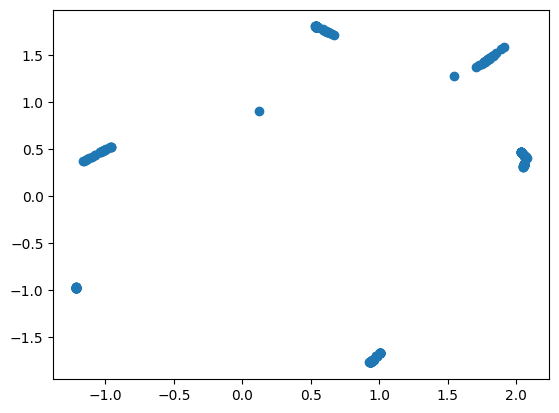

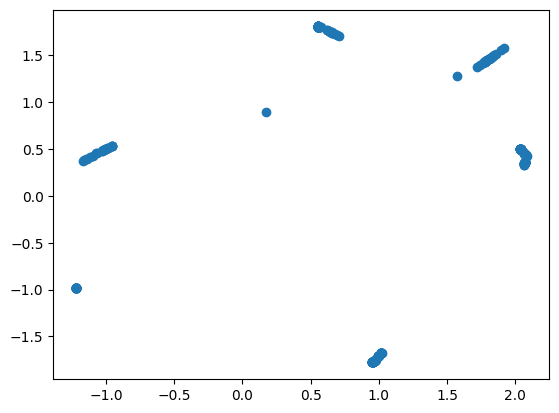

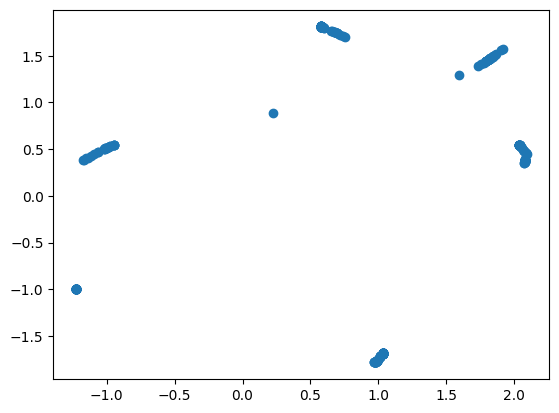

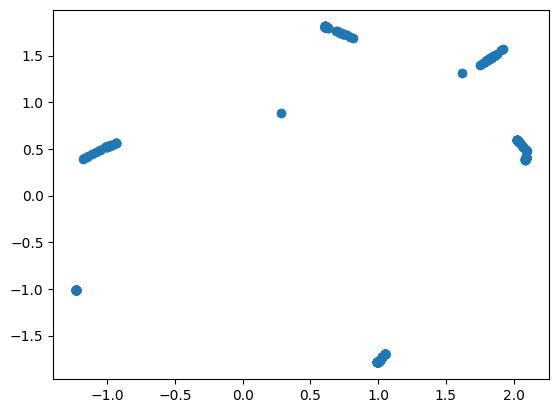

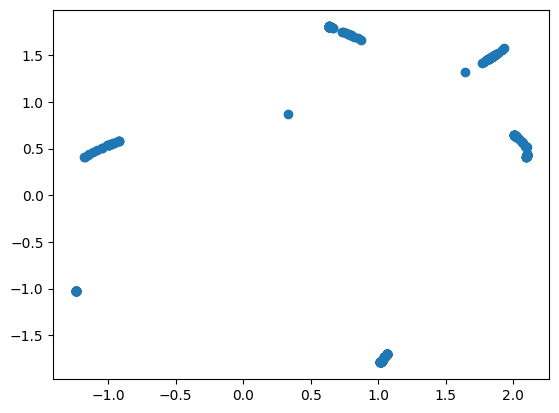

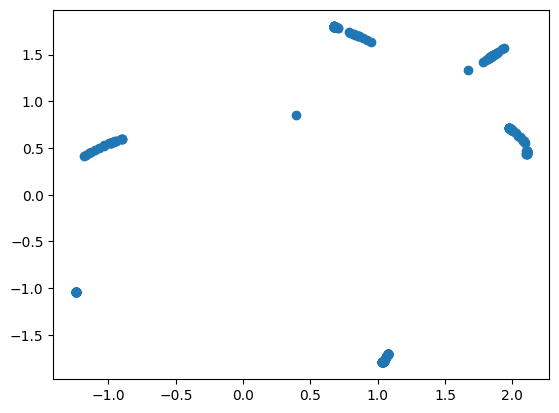

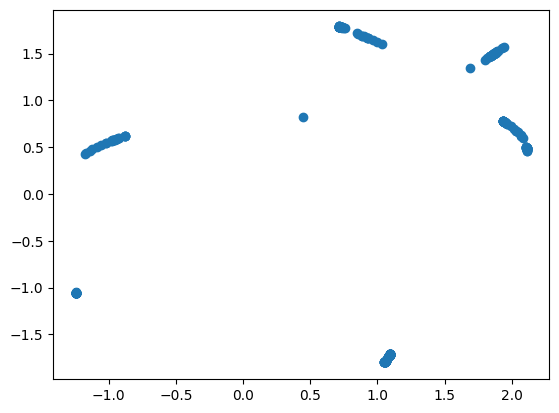

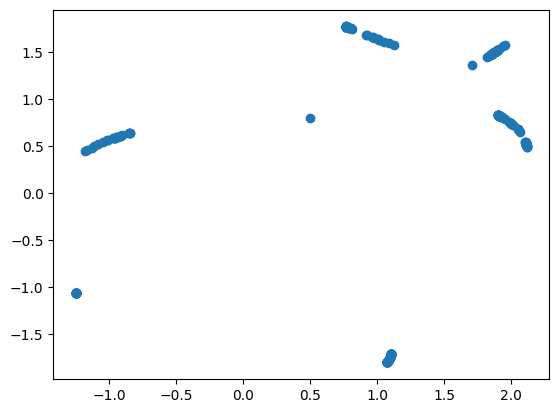

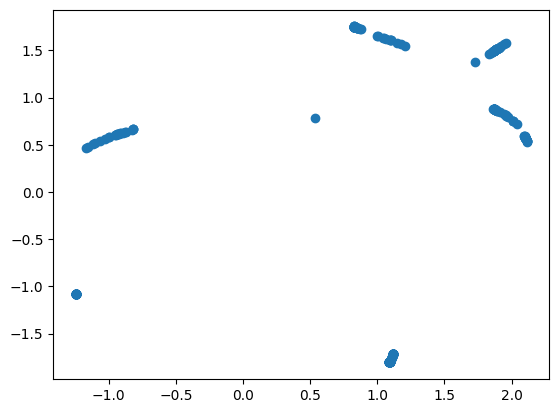

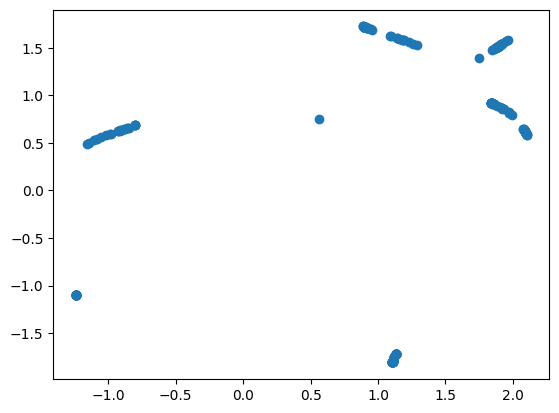

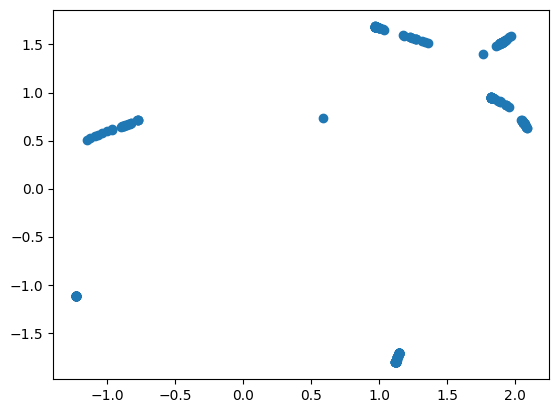

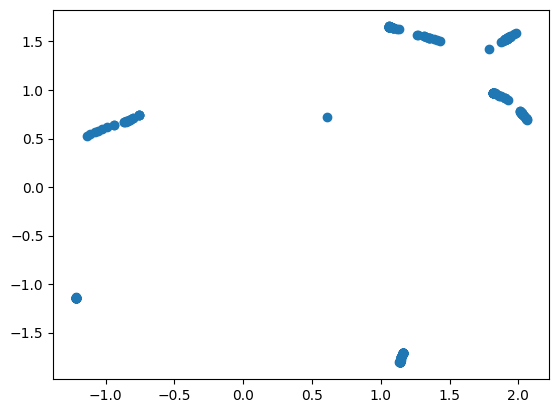

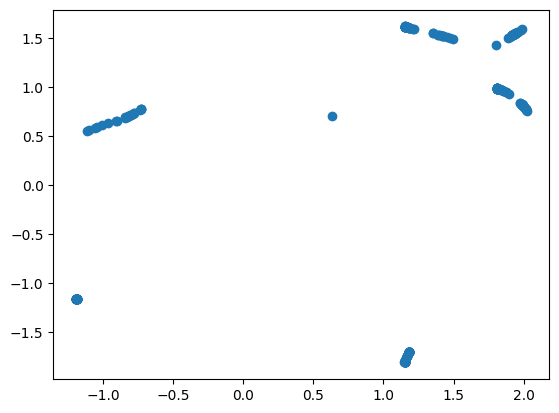

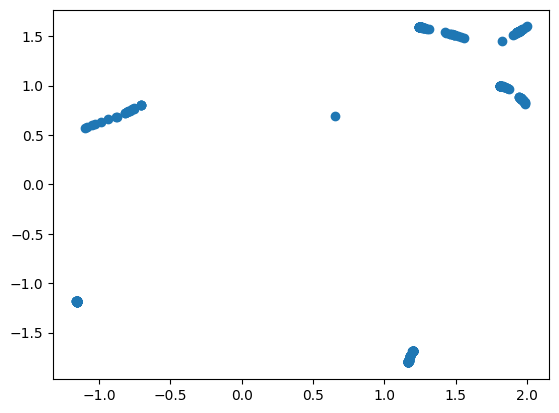

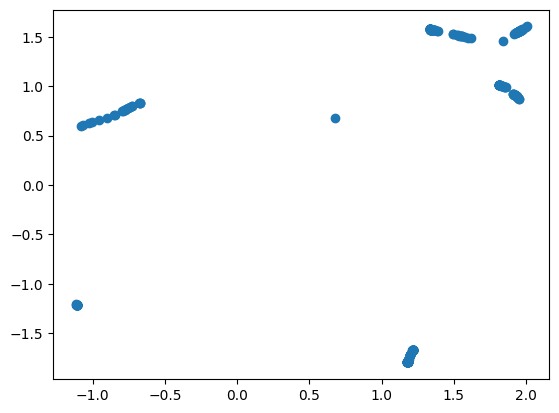

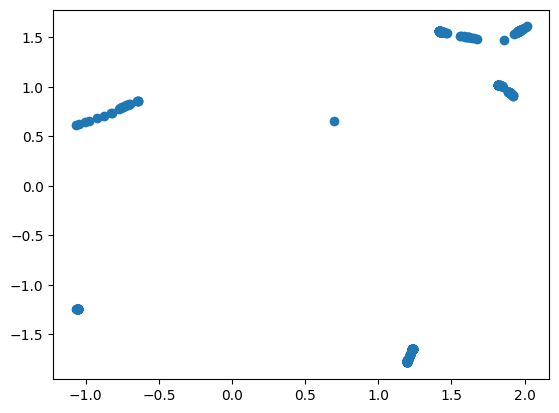

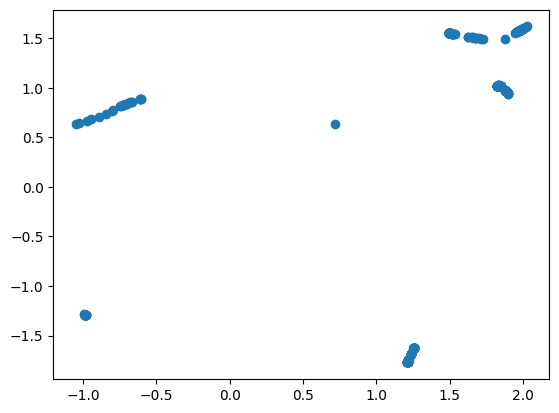

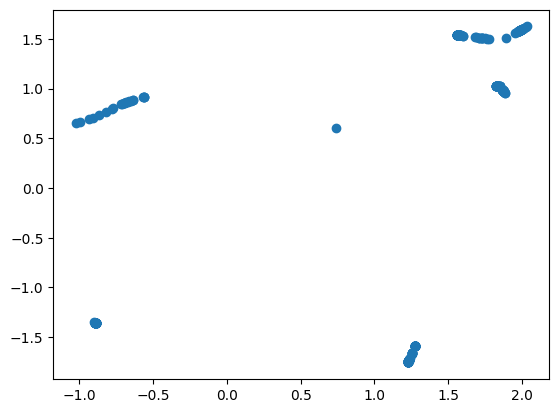

In [44]:
for i in range(xs.shape[0]):
    fig, ax = plt.subplots()
    ax.scatter(xs[i, :, 0], xs[i, :, 1])
xs.shape

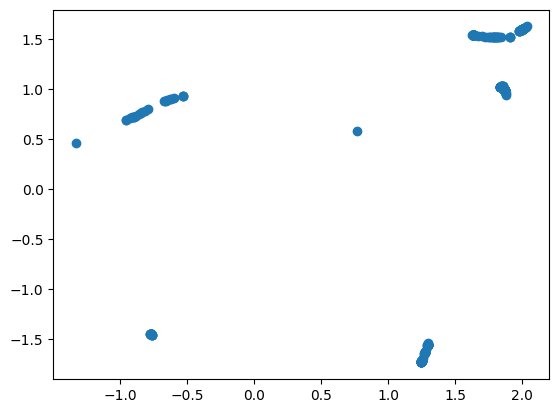

In [41]:
fig, ax = plt.subplots()

#z0 = z0.cpu().data.numpy()
xT = xT.cpu().data.numpy()
ax.scatter(xT[:,0], xT[:,1])

In [20]:
koop.encode(xT, torch.Tensor([20]))


tensor([[-2.1186,  0.2097,  0.6892,  ...,  1.7684,  0.5481,  0.4271],
        [-2.0153,  0.1216,  1.7365,  ...,  1.3701, -0.8964, -0.2583],
        [-2.1344,  0.2003,  0.7999,  ...,  1.7730,  0.4510,  0.3595],
        ...,
        [-1.2753,  0.2779, -0.1576,  ...,  0.9211,  0.9743,  0.7083],
        [-1.8652,  0.2358,  0.3374,  ...,  1.5126,  0.7490,  0.5481],
        [-2.1306,  0.1868,  0.8877,  ...,  1.7499,  0.3616,  0.3068]],
       grad_fn=<AddmmBackward0>)

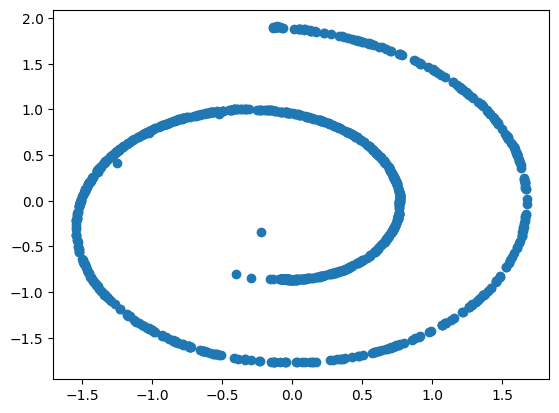

In [28]:
fig, ax = plt.subplots()

ax.scatter(samples[-1,:,0], samples[-1,:,1])